### Importa librerie

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from adjustText import adjust_text
from custom.watermarks import add_watermark

### Definizione funzioni

In [2]:
def get_vaccine_data(country, time_window=30, fully=False):
    """ Recupera dati sulla frazione di vaccinati medi negli ultimi time_window giorni (default = 30)"""
    df_vacc_country2 = df_global[df_global["location"] == country]
    df_vacc_country = df_vacc_country2.fillna(method='ffill').copy()
    if fully==False:
        vacc_fully = np.array(df_vacc_country["people_vaccinated_per_hundred"][-(time_window+1):-1])
    else:
        vacc_fully = np.array(df_vacc_country["people_fully_vaccinated_per_hundred"][-(time_window+1):-1])
    
    vacc_ultimi_Ngiorni = np.mean(vacc_fully)   
    return vacc_ultimi_Ngiorni

def get_deaths(country, time_window=30):
    """ Recupera dati sul numero assoluto di decessi negli ultimi time_window giorni (default = 30)"""
    decessi = np.array(df_global[df_global["location"] == country]['total_deaths'])
    decessi_ultimi_Ngiorni = decessi[-1] - decessi[-(time_window+1)]
    return decessi_ultimi_Ngiorni

def get_value_from_df(countries, column, scale_factor=1):
    """ Recupera l'ultimo valore della column specificata, per la lista di countries, e moltiplica per scale_factor (default = 1)"""
    values = []
    for el in countries:
         values.append(df_global[df_global["location"] == el][column].tolist()[-1]*scale_factor)
    return values

### Importa dati da Our World in Data

In [3]:
file_owid = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
df_global = pd.read_csv(file_owid)

In [4]:
# Dataframe solo per paesi europei
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 
                'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 
                'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']
df_europe = df_global.loc[df_global['location'].isin(eu_countries)]

### Calcola morti e vaccinati

In [5]:
# Definizione paesi e relative label
paesi = eu_countries
paesi_label = ['Austria', 'Belgio', 'Bulgaria', 'Croazia', 'Cipro', 'Repubblica Ceca', 'Danimarca', 'Estonia', 'Finlandia', 
                'Francia', 'Germania', 'Grecia', 'Ungheria', 'Irlanda', 'Italia', 'Lettonia', 'Lituania', 'Lussemburgo', 
                'Malta', 'Paesi Bassi', 'Polonia', 'Portogallo', 'Romania', 'Slovacchia', 'Slovenia', 'Spagna', 'Svezia']

# Calcola vaccinati e decessi
abitanti = get_value_from_df(paesi, 'population', scale_factor=1e-6)

# Crea dizionario
abitanti_dict = dict(zip(paesi, abitanti))

In [6]:
dec_res=[] # Decessi per milione di abitanti ultimi tw_death giorni
vacc_res=[] # % vaccinati media ultimi tw_vacc giorni

tw_death = 30
tw_vacc = 30
for i in range(len(paesi)):
    vacc_res.append(get_vaccine_data(paesi[i], time_window = tw_vacc, fully=False))
    dec_res.append(get_deaths(paesi[i], time_window = tw_death)/abitanti_dict[paesi[i]])

### Aggiungi altre grandezze

In [7]:
# Definisci dati estratti da df_europe
columns = ['gdp_per_capita', 
           'population_density', 
           'aged_70_older', 
           'extreme_poverty', 
           'diabetes_prevalence', 
           'hospital_beds_per_thousand', 
           'life_expectancy', 
          ]

In [8]:
data_for_model = []

# Estrai dati da df_europe e aggiungili a data_for_model
for el in columns:
    data_for_model.append(get_value_from_df(paesi, el))

# Aggiungi manualmente dati di latitudine, vaccinati, morti
latitude = [47.516231, 50.503887, 42.733883, 45.1, 35.126413, 49.817492, 56.26392, 58.595272, 61.92411, 46.227638, 51.165691, 39.074208, 47.162494, 53.41291, 41.87194, 56.879635, 55.169438, 49.815273, 35.937496, 52.132633, 51.919438, 39.399872, 45.943161, 48.669026, 46.151241, 40.463667, 60.128161]
data_for_model.append(vacc_res)
data_for_model.append(latitude)    
data_for_model.append(dec_res)

# Aggiungi manualmente colonne di latitudine, vaccinati, morti
columns.append(f'Perc_vacc_last_{tw_vacc}_days')
columns.append('latitude')    
columns.append(f'Deaths_last_{tw_death}_days')

# Trasponi data_for_model
data_for_model = list(map(list, zip(*data_for_model)))

### Crea DataFrame

In [9]:
df_europe_small = pd.DataFrame(data_for_model, columns=columns).round(decimals=2)

# Aggiungi colonna 'Country' e rendila indice
df_europe_small = df_europe_small.assign(Country=pd.Series(paesi_label).values)
df_europe_small.set_index('Country', inplace=True)
df_europe_small.head(20)

,gdp_per_capita,population_density,aged_70_older,extreme_poverty,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,Perc_vacc_last_30_days,latitude,Deaths_last_30_days
Country,,,,,,,,,,
Austria,45436.69,106.75,13.75,0.7,6.35,7.37,81.54,65.44,47.52,61.37
Belgio,42658.58,375.56,12.85,0.2,4.29,5.64,81.63,74.93,50.50,49.35
Bulgaria,18563.31,65.18,13.27,1.5,5.81,7.45,75.05,21.68,42.73,593.19
Croazia,22669.80,73.73,13.05,0.7,5.59,5.54,78.49,47.02,45.10,249.65
Cipro,32415.13,127.66,8.56,NaN,9.24,3.40,80.98,67.46,35.13,30.13
Repubblica Ceca,32605.91,137.18,11.58,NaN,6.82,6.63,79.38,58.22,49.82,88.86
Danimarca,46682.52,136.52,12.32,0.2,6.41,2.50,80.90,77.08,56.26,16.17
Estonia,29481.25,31.03,13.49,0.5,4.02,4.69,78.74,59.84,58.60,194.69
Finlandia,40585.72,18.14,13.26,NaN,5.76,3.28,81.91,76.07,61.92,18.02


coefficiente di correlazione -0.79


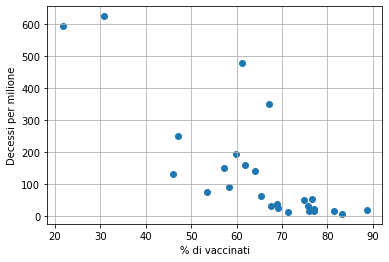

In [10]:
x = df_europe_small['Perc_vacc_last_30_days']
y = df_europe_small['Deaths_last_30_days']
corr_coef = round(np.corrcoef(x, y)[0, 1], 2)

print('coefficiente di correlazione', corr_coef)

plt.scatter(x, y)
plt.xlabel('% di vaccinati')
plt.ylabel('Decessi per milione')
plt.grid()
plt.show()

### Matrice di correlazione

In [11]:
corr = df_europe_small.corr()

# Plotta solo metà matrice di correlazione
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1'))  # Color NaNs grey

,gdp_per_capita,population_density,aged_70_older,extreme_poverty,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,Perc_vacc_last_30_days,latitude,Deaths_last_30_days
gdp_per_capita,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
population_density,0.130141,nan,nan,nan,nan,nan,nan,nan,nan,nan
aged_70_older,-0.318411,-0.135075,nan,nan,nan,nan,nan,nan,nan,nan
extreme_poverty,-0.356608,-0.172012,0.118310,nan,nan,nan,nan,nan,nan,nan
diabetes_prevalence,-0.326223,0.252022,-0.078269,0.385693,nan,nan,nan,nan,nan,nan
hospital_beds_per_thousand,-0.314582,-0.065464,0.076891,0.293696,0.137327,nan,nan,nan,nan,nan
life_expectancy,0.518650,0.287622,0.103775,-0.309593,-0.052046,-0.626304,nan,nan,nan,nan
Perc_vacc_last_30_days,0.433800,0.320431,0.167746,-0.544483,-0.083999,-0.600808,0.766593,nan,nan,nan
latitude,0.268820,-0.357938,0.031547,-0.235576,-0.529349,-0.034396,-0.180750,0.014052,nan,nan
Deaths_last_30_days,-0.493300,-0.266516,0.083975,0.609906,0.023185,0.499863,-0.852419,-0.794623,0.034070,nan


### Modello con regressione lineare

In [12]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [13]:
# Definisci dati per modello
X = df_europe_small.drop([f'Deaths_last_{tw_death}_days'], axis=1)
# Riempi i NaN con median/mean
X.fillna(X.median(), inplace=True)
# Scala dati
scaler = StandardScaler()
X[X.columns.tolist()] = scaler.fit_transform(X[X.columns.tolist()])

Y = df_europe_small[f'Deaths_last_{tw_death}_days']

In [14]:
# # LINEAR REGRESSION
# # Crea modello e stampa dati
#regr = linear_model.LinearRegression()
#regr.fit(X, Y)
#score = regr.score(X, Y)

#print('Intercetta: \n', regr.intercept_) 
#print('Coefficienti: \n', regr.coef_)
#print('R2 Score', score)

In [15]:
# LASSO
# Crea modello e stampa dati
# alpha_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
alpha_list = [0.001]
for el in alpha_list:
    regr = linear_model.Lasso(alpha=el)
    regr.fit(X, Y)
    score = regr.score(X, Y)

#     print('Intercetta: \n', regr.intercept_)
#     print('Coefficienti: \n', regr.coef_)
    print('R2 Score', score)

R2 Score 0.9326946422729606


In [16]:
# LOO
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

# Create scorer
mae_scorer = make_scorer(mean_absolute_error)

# Implement LOOCV
loocv_scores = cross_val_score(regr, X=X, y=y, cv=27, scoring=mae_scorer)

# Print the mean and standard deviation
print("Mean of the errors is: %s." % np.mean(loocv_scores))
print("Standard deviation of the errors is: %s." % np.std(loocv_scores))

Mean of the errors is: 76.18453616255736.
Standard deviation of the errors is: 90.41951407543708.


watermark fontsize: 15, angle:-26.57


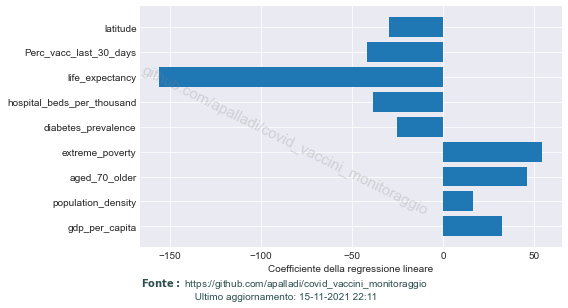

In [18]:
# Stampa grafico dei coefficienti
plt.style.use('seaborn-dark')
fig, ax = plt.subplots(figsize=(8, 4))
plt.barh(X.columns, regr.coef_)
plt.xlabel('Coefficiente della regressione lineare')
plt.grid()
ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())
plt.tight_layout()
plt.savefig('../risultati/coefficienti.png', dpi=300, bbox_inches="tight")
plt.show()

In [19]:
import statsmodels.api as sm
# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                             OLS Regression Results                            
Dep. Variable:     Deaths_last_30_days   R-squared:                       0.933
Model:                             OLS   Adj. R-squared:                  0.897
Method:                  Least Squares   F-statistic:                     26.18
Date:                 Mon, 15 Nov 2021   Prob (F-statistic):           3.04e-08
Time:                         22:11:08   Log-Likelihood:                -141.14
No. Observations:                   27   AIC:                             302.3
Df Residuals:                       17   BIC:                             315.2
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const     

### Feature importance con RF

In [20]:
# from sklearn.ensemble import RandomForestRegressor

# # Definisci modello
# RF_model = RandomForestRegressor(max_depth=10, random_state=42)
# RF_model.fit(X, Y)

# # Plotta importanza feature
# for i, el in enumerate(X.columns):
#     print(f'Feature: {el}, importance: {RF_model.feature_importances_[i]*100:.2f}')

In [21]:
# Risultati su morti 7 mesi:
# Feature: const, importance: 0.00
# Feature: gdp_per_capita, importance: 39.72
# Feature: population_density, importance: 1.51
# Feature: aged_70_older, importance: 1.39
# Feature: extreme_poverty, importance: 2.68
# Feature: diabetes_prevalence, importance: 1.24
# Feature: hospital_beds_per_thousand, importance: 2.60
# Feature: life_expectancy, importance: 44.23
# Feature: Perc_vacc_last_7_days, importance: 5.05
# Feature: latitude, importance: 1.57